In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy      as np
import scipy      as sp
import tensorflow as tf
import sionna     as sn

%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from sionna.channel.tr38901 import AntennaArray, UMa
from sionna.channel         import gen_single_sector_topology as gen_topology

In [4]:
## System Parameters
carrierFrequency = 3.6*10**9        # Carrier frequency 3.6 GHz
scs         = 30*(10**3)            # Subcarrier spacing for simulation
bandwidthTx = 10*(10**6)            # Transmission bandwidth
nSymbolFrame= 140*int(scs/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)

## This class fetches valid set of 5G parameters for the system configurations 
nRB         = 40            # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = nRB*12        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
Nfft        = 512           # FFT-size for OFDM
lengthCP    = 36            # CP length
#___________________________________________________________________

## Number of batches | Number of Transmitter | Number of Receivers | 
## Number of Symbols | Number of Tx-Antennas | Number of Rx-Antennas

numUEs      = 10     # Number of UE condsidered for Simulation
Nr_x        = 2      # Number of antennas placed Horizontally at Receiver (2D Antenna Panels)
Nr_y        = 2      # Number of antennas placed Vertically   at Receiver (2D Antenna Panels)
Polr        = 2      # Polarization of Receiver antennas

numBSs      = 1      # Number of BSs condsidered for Simulation
Nt_x        = 8      # Number of antennas placed Horizontally at Transmitter (2D Antenna Panels)
Nt_y        = 8      # Number of antennas placed Vertically   at Transmitter (2D Antenna Panels)
Polt        = 2      # Polarization of Transmitter antennas
 
nBatch      = 1      # Number of Batches considerd for Simulations (Similar to Monte-carlo)

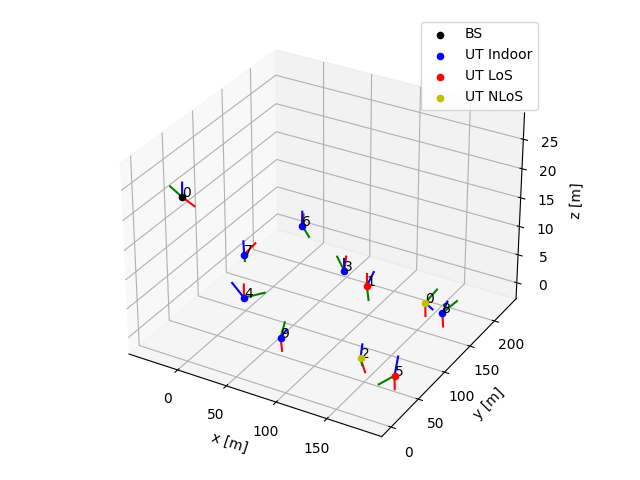

In [5]:
scenario          = "uma"
direction         = "downlink"

# tf.random.set_seed(np.random.randint(2**32))

txGridObj_ch  = sn.ofdm.ResourceGrid(num_ofdm_symbols = 1, 
                                     fft_size = Nfft, 
                                     subcarrier_spacing = scs, 
                                     num_tx = 1, 
                                     num_streams_per_tx   = 1, 
                                     cyclic_prefix_length = lengthCP, 
                                     num_guard_carriers   = (int((Nfft-Neff)/2), int((Nfft-Neff)/2)), 
                                     dc_null = False, 
                                     pilot_pattern = None, 
                                     pilot_ofdm_symbol_indices = None,
                                     dtype = tf.complex64)

if(Polt==1):
    # Define the BS antenna array
    bs_array = AntennaArray(num_rows=Nt_y, num_cols=Nt_x, polarization="single",
                            polarization_type="V", antenna_pattern="38.901",
                            carrier_frequency=carrierFrequency) 
else:
    # Define the BS antenna array
    bs_array = AntennaArray(num_rows=Nt_y, num_cols=Nt_x, polarization="dual",
                            polarization_type="cross", antenna_pattern="38.901",
                            carrier_frequency=carrierFrequency)

if(Polr==1):
    # Define the BS antenna array
    ut_array = AntennaArray(num_rows=Nr_y, num_cols=Nr_x, polarization="single",
                            polarization_type="V", antenna_pattern="38.901",
                            carrier_frequency=carrierFrequency)
else:
    # Define the BS antenna array
    ut_array = AntennaArray(num_rows=Nr_y, num_cols=Nr_x, polarization="dual",
                            polarization_type="cross", antenna_pattern="38.901",
                            carrier_frequency=carrierFrequency)


# Create channel model
channel_model = UMa(carrier_frequency=carrierFrequency, o2i_model="low",
                    ut_array=ut_array, bs_array=bs_array, direction=direction,
                    enable_pathloss=True, enable_shadow_fading=True)

# Generate the topology
topology = gen_topology(nBatch, numUEs, scenario)

# Set the topology
channel_model.set_topology(*topology, )

# Visualize the topology
channel_model.show_topology()

# OFDM Channel Generation 
H_obj  = sn.channel.GenerateOFDMChannel(channel_model, txGridObj_ch, normalize_channel=False, dtype = tf.complex64)
H_ofdm = H_obj(1).numpy()[0,:,:,0,...,0,:].transpose(0,-1,1,2)   # Shape: Number of UEs x FFT-Size x Number of UE Antennas x Number of BS Antennas 

In [6]:
H_ofdm.shape

(10, 512, 8, 128)

## Channel Capacity: SU-MIMO

In [7]:
k_Bolt    = 1.380649*(10**(-23));
Temp      = 300;
Bandwidth = Nfft*scs;
n0        = k_Bolt*Temp*Bandwidth

Nr = Nr_x*Nr_y*Polr
Nt = Nt_x*Nt_y*Polt

Pt_dB     = np.linspace(23, 43, 10)
Pt        = 10**(0.1*(Pt_dB-30))
SNR       = Pt/n0
capacity  = np.zeros(SNR.size, )

H_Hh = H_ofdm@H_ofdm.conj().transpose(0,1,3,2)

i = 0
for snr in SNR:
    capacity[i]  = (1/Nfft)*np.mean(np.sum(np.log(np.abs(np.linalg.det(np.tile(np.eye(Nr)[np.newaxis, np.newaxis, ...], 
                                                               [numUEs, Nfft,1,1]) + snr/Nt*H_Hh))), axis = -1))
    i            = i + 1

In [8]:
H_ofdm.shape

(10, 512, 8, 128)

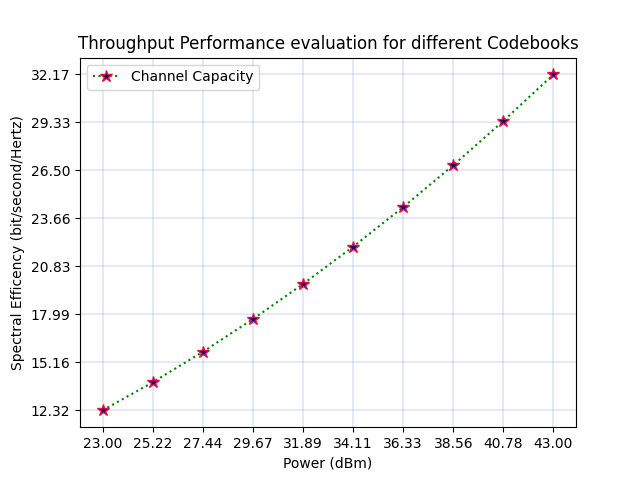

In [9]:
fig, ax = plt.subplots()

ax.plot(Pt_dB, capacity, 'g:', marker = "*", ms = 9, mec = "crimson", mfc = "darkblue", label = "Channel Capacity")
ax.set_xlabel("Power (dBm)")
ax.set_ylabel("Spectral Efficency (bit/second/Hertz)")
ax.set_title("Throughput Performance evaluation for different Codebooks")
ax.set_xticks(Pt_dB)
ax.set_yticks(np.linspace(capacity[0], capacity[-1], 8))
ax.grid(color = "royalblue", linewidth = "0.2")
ax.legend()
plt.show()

## SVD based Precoding

In [72]:
U,S, Vh = np.linalg.svd(H_ofdm)

In [82]:
O = 8
F = np.fft.fft(np.eye(Nt*O), norm="ortho")
Vbeam = F[:,0:Nt]@np.conj(Vh[1,1]).T@np.conj(F[:,0:Nt]).T

In [90]:
Vbeam[0,0]/Vbeam[100,100]

(0.9878954693936611+0.023394154332130435j)

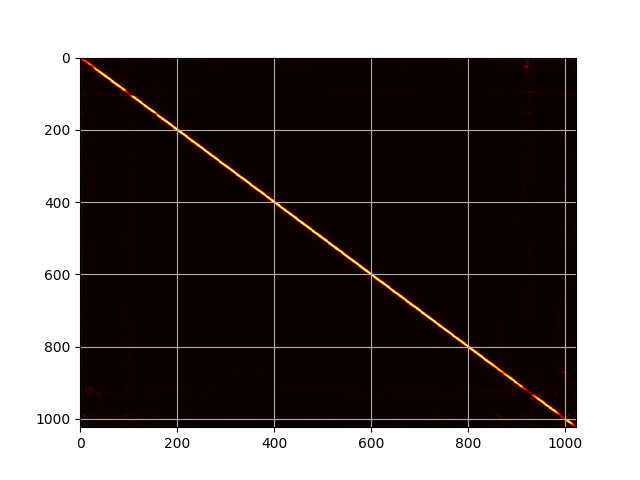

In [87]:
fig, ax = plt.subplots()

ax.imshow(np.abs(Vbeam)**2, cmap = 'hot', interpolation='nearest', aspect = "auto")
ax.grid()
plt.show()